<a href="https://colab.research.google.com/github/developerabhi14/ML-Notebooks/blob/main/Diffusion_model_from_scratch_using_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q diffusers

In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", {device})

Using device: {device(type='cuda')}


# Dataset

In [3]:
dataset=torchvision.datasets.FashionMNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.64MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.4MB/s]


In [4]:
train_dataloader=DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([0, 9, 2, 7, 5, 9, 8, 5])


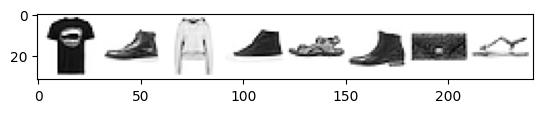

In [5]:
x,y=next(iter(train_dataloader))
print('Input shape:',x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

Each image is of shape 28*28pxand the image is grayscale. The above shape is [batch_size, channel_dimension, height, width]


# Noise Addition Process

How would we add noise to the image?

We would want an easy way to control the amount of corruption. So what if we take in a parameter for the noise to add

**noise=torch.rand_like(x)** <br>
**noisy_x=(1-amount) x X + amount x noise** <br><br>

If amount=0, we get back the input without any changes. If amount gets upto 1, we get back noise with no trace of input x. By mixing the input with noise this way, we keep the output in same range(0,1)

In [6]:
def corrupt(x,amount):
  noise=torch.rand_like(x)
  amount=amount.view(-1,1,1,1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount

And looking at the results to see if it works as we expected

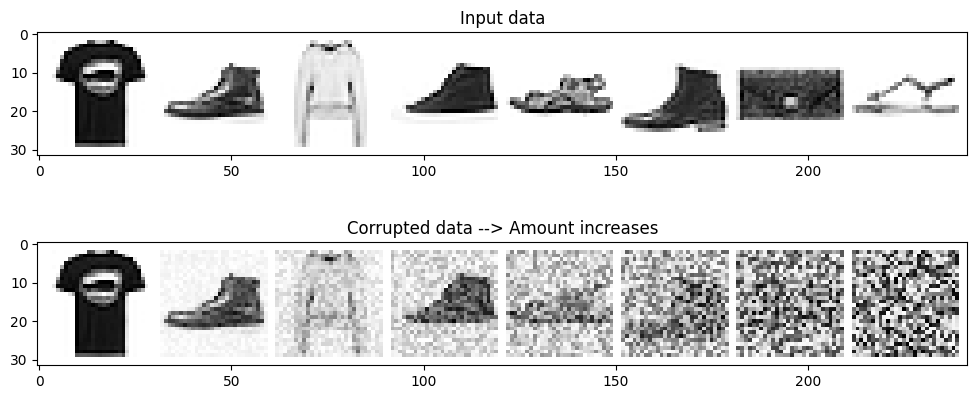

In [7]:
# Plotting the input data
fig,axs=plt.subplots(2,1,figsize=(12,5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0],cmap="Greys")

# Adding noise
amount=torch.linspace(0,1,x.shape[0]) # Left to right-> more corruption
noised_x=corrupt(x,amount)

# Plotting the noised version
axs[1].set_title('Corrupted data --> Amount increases')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0],cmap="Greys")

# Model

We would like to have a model that takes in 28px noisy images and outputs a prediction of same shape. We choose UNet architecture. Here is a rough UNet architecture model

In [8]:
class BasicUNet(nn.Module):
  """Minimal UNet Architecture"""
  def __init__(self, in_channels=1, out_channels=1):
    super().__init__()
    self.down_layers=torch.nn.ModuleList([
        nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
        nn.Conv2d(32,64, kernel_size=5, padding=2),
        nn.Conv2d(64,64, kernel_size=5, padding=2),
    ])

    self.up_layers=torch.nn.ModuleList([
        nn.Conv2d(64, 64, kernel_size=5, padding=2),
        nn.Conv2d(64,32, kernel_size=5, padding=2),
        nn.Conv2d(32,out_channels, kernel_size=5, padding=2),
    ])
    self.act=nn.SiLU() # Activation function
    self.downscale=nn.MaxPool2d(2)
    self.upscale=nn.Upsample(scale_factor=2)


  def forward(self, x):
    h=[]
    for i,l in enumerate(self.down_layers):
      x=self.act(l(x)) # Through the layer and the activatin function
      if i<2: # For all but the third (final) down layer
        h.append(x) # Storing output for skip connection
        x=self.downscale(x) # Downscale ready for next layer

    for i,l in enumerate(self.up_layers):
      if i>0: # For all except the first up layer
        x=self.upscale(x) # Upscale
        x += h.pop() # Fetching stored output (skip connection)
      x = self.act(l(x)) # Through the layer and the activation function

    return x

We can verify that the output shape is the same as the input, as we except

In [9]:
net=BasicUNet()
x=torch.rand(8,1,28,28)
net(x).shape

torch.Size([8, 1, 28, 28])

The network has just over 300,000 parameters

In [10]:
sum([p.numel() for p in net.parameters()])

309057

# Training The Network

Given a corrupted input noisy_x, the model should utput its best guess for what the original x looks like. We will compare this to the actual value via the mean squared error

  1) Get a batch of data <br>
  2) Corrupt it by random amounts <br>
  3) Feed it through the model <br>
  4) Comapre the model predctions with the clean images to calculate our loss <br>
  5) Update the model's parameters accordingly <br>


finished epoch 0. Average loss for the epoch: 0.033035
finished epoch 1. Average loss for the epoch: 0.025239
finished epoch 2. Average loss for the epoch: 0.022390
finished epoch 3. Average loss for the epoch: 0.020921
finished epoch 4. Average loss for the epoch: 0.020128
finished epoch 5. Average loss for the epoch: 0.019521
finished epoch 6. Average loss for the epoch: 0.019176
finished epoch 7. Average loss for the epoch: 0.018763
finished epoch 8. Average loss for the epoch: 0.018407
finished epoch 9. Average loss for the epoch: 0.018362


(0.0, 0.1)

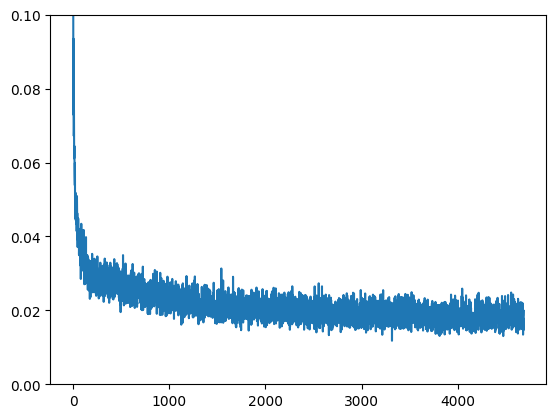

In [11]:
# Dataloader
batch_size=128
train_dataloader=DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How may runs through the data should we do?
n_epochs=10

# Create the network
net=BasicUNet()
net.to(device)

# Loss Function
loss_fn=nn.MSELoss()

# Optimizer
opt=torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later vieweing
losses=[]

# Training loop
for epoch in range(n_epochs):
  for x,y in train_dataloader:
    # GEt some data and prepare the corrupted version
    x=x.to(device)
    noise_amount=torch.rand(x.shape[0]).to(device) # pick random noise amounts
    noisy_x=corrupt(x,noise_amount) # Createa our noisy x

    # Get model prediction
    pred=net(noisy_x)

    # Calculate loss
    loss=loss_fn(pred,x)

    # Backward and update the params
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Store the loss for later
    losses.append(loss.item())

  avg_loss=sum(losses[-len(train_dataloader):])/len(train_dataloader)
  print(f"finished epoch {epoch}. Average loss for the epoch: {avg_loss:05f}")

plt.plot(losses)
plt.ylim(0,0.1)

We can see what the model predictions look like by grabbing a batch of data, corrupting it by different amounts and then seeing the models predictions

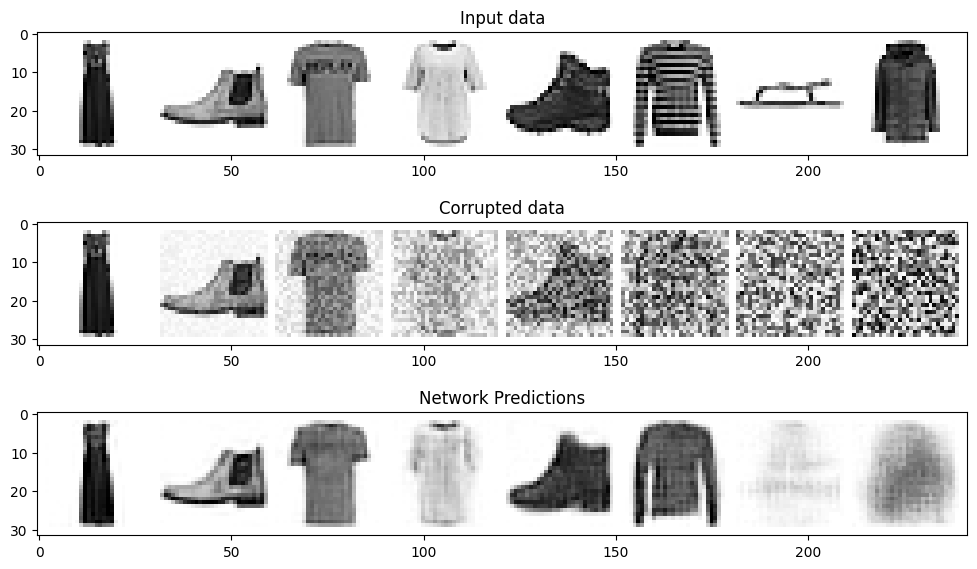

In [12]:
#  Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

We can see that for lower amount of corruption the predictions are good. But as the corruption level increases there is less for the model to work with, and by the time we get to amount=1, it outputs a blurry mess close to the mean of the dataset and shows what the output might look like in its opinion

# Sampling

If our predictions at high noise levels are not very good, how do we generate images?

Well, what if we start from random noise, look at model predictions but then only move a small amount towards that (say 20%), of the way there. Now we have a very noisy image in which perhaps there is a hint of structure, which we can feed into the model to get a new prediction. The hope is that this new prediction is slightly better than the first one(since out starting point is slightly less noisy) and so we can take another small step with htis new, better prediction

Repeat a few times and if all goes well, we get an image out Here is that process illustrated over just 5 steps, visualizing the model input(left) and predicted denoised imags(right) at each state. Note that even though the model predicts the denoised image even at step 1, we only move x part of he way there. Over a few steps the structure appear and are refined, until we get our final outputs.

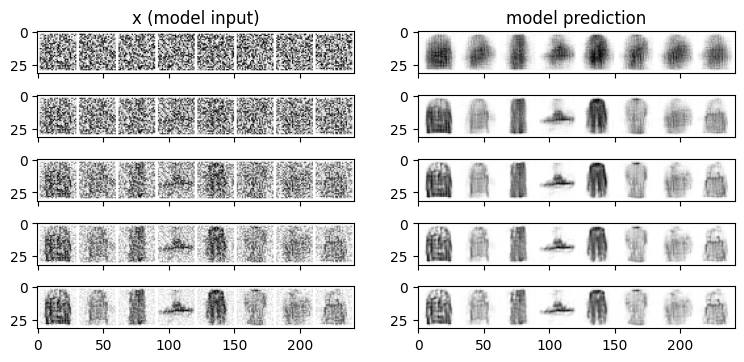

In [13]:
# Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

We can split the process up into more steos, and hope for better images that way

Here is the one done with 40 sampling steps

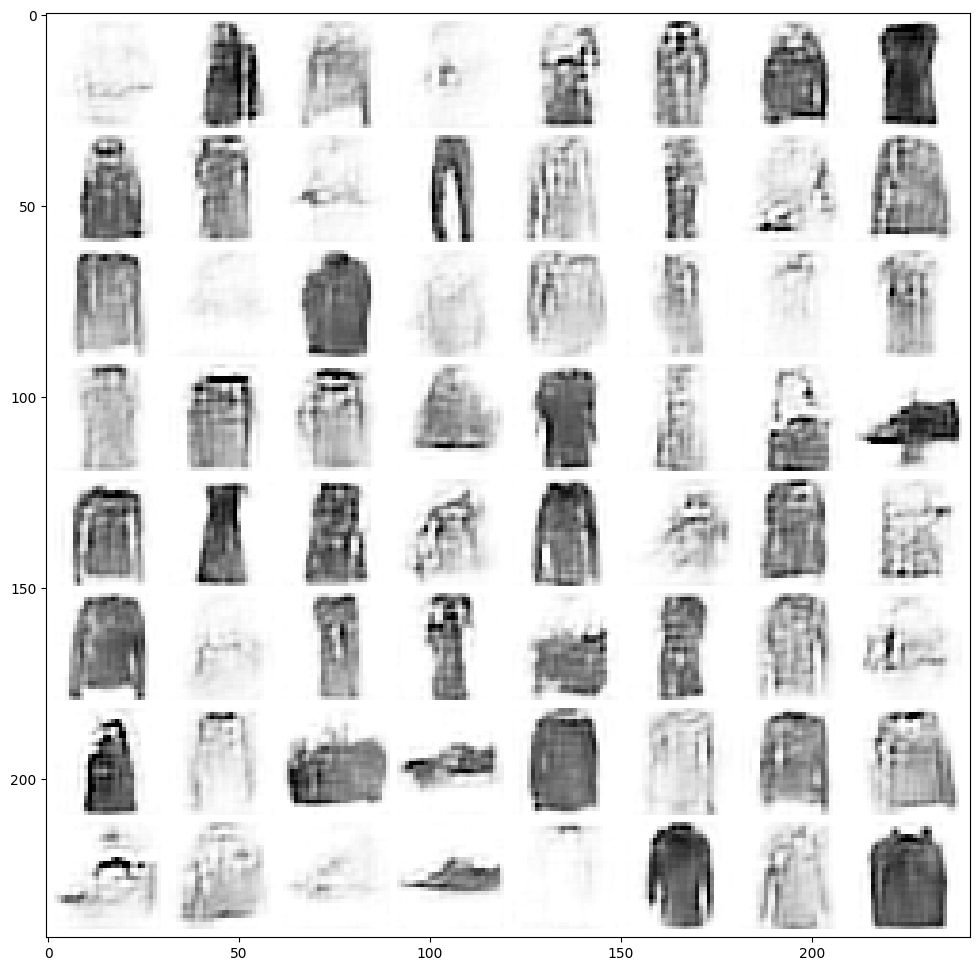

In [14]:
# Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

Not that great , but there are some recognizable digits there. Try more epochs of training and tweaking model parameters like model config, learning rate, optimizer and so on. And don't forget fashionMNIST is a one line replacement if you want a slightly harder dataset to try


# The Corruption Process

The DDPM paper describse a corruption process that adds a small amount of noise for every 'timestep'.

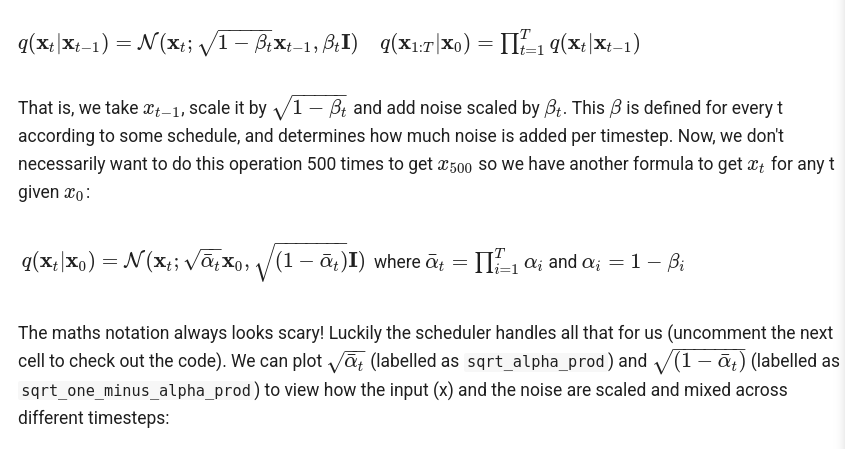


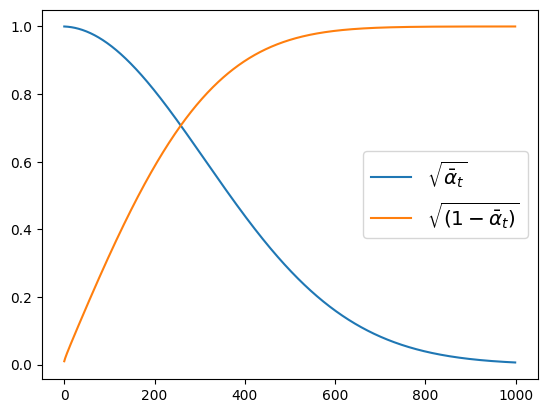

In [15]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


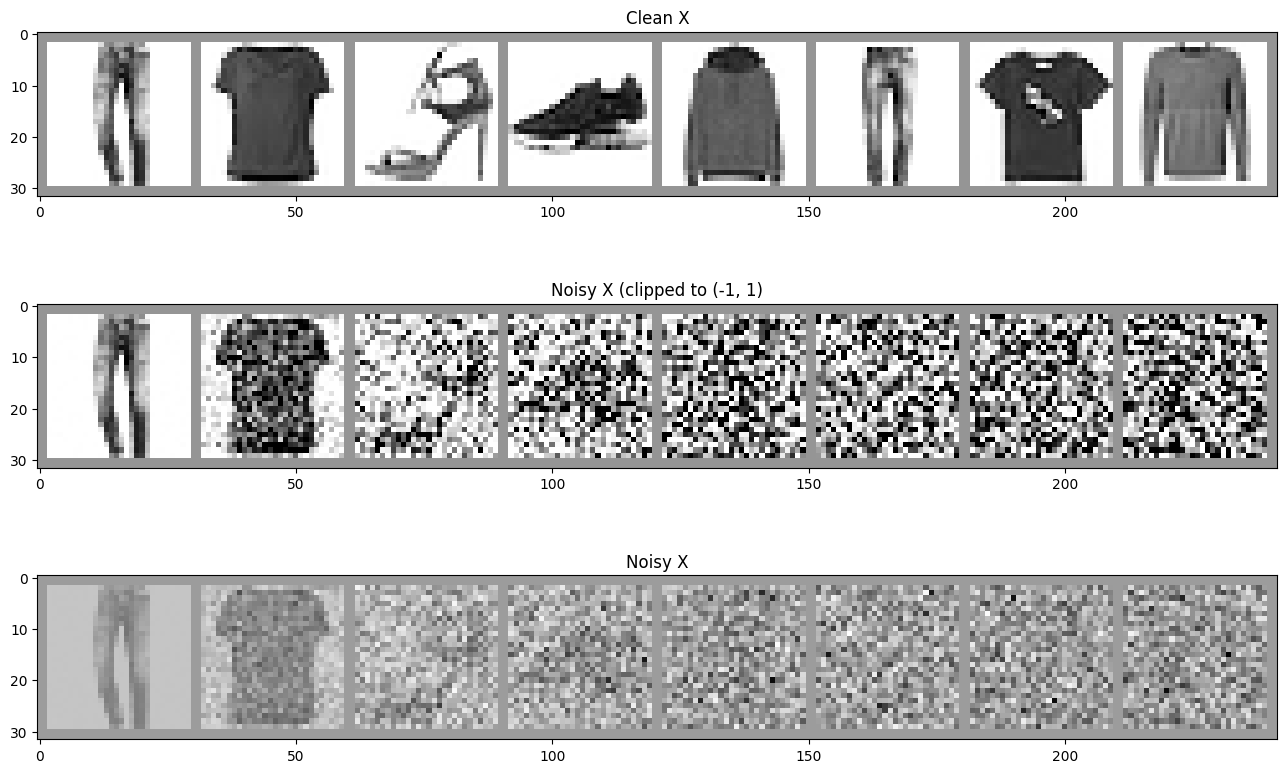

In [16]:
# visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');